주택 가격 예측을 위해 머신러닝 모델을 구축하고 평가하는 과정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

#데이터 불러오기
try:
    data = pd.read_csv('Data/test.csv', encoding='utf-8')
    train = pd.read_csv('Data/train.csv', encoding='utf-8')
except UnicodeDecodeError:
    #UTF-8로 실패한 경우 CP949로 재시도
    data = pd.read_csv('Data/test.csv', encoding='cp949')
    train = pd.read_csv('Data/train.csv', encoding='cp949')    

UTF-8로 인코딩된 파일을 불러오지 못할 경우 CP949로 다시 시도

In [20]:
data.head()
train.head()
data.tail()
train.tail()

#data1: house_id	price
#data2:	house_id	date	location	type	block	street	storey_range	area_sqm	flat_model	commence_date
#data3:	house_id	date	location	type	block	street	storey_range	area_sqm	flat_model	commence_date	price

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price
271716,101563,2003-01,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0
271717,28297,2000-11,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0
271718,321995,2011-04,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0
271719,308162,2010-09,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0
271720,225691,2007-10,Milwaukee,EXECUTIVE,341,W Fond du Lac Avenue,04 TO 06,143.0,C,1993,450000.0


데이터의 처음과 마지막 몇 행을 출력해 데이터 구조를 확인

INFO: datasets 라이브러리는 주로 자연어 처리(NLP)와 관련된 데이터셋을 다루기 위해 사용됩니다. 이 라이브러리에서는 Dataset 객체를 생성할 때 일반적으로 train, validation, test와 같은 분할을 사용합니다. 따라서, train은 데이터셋의 특정 분할을 나타내기 위한 것이며, 개별 컬럼이 아닙니다.

EDA

In [24]:
#기초 통계량 확인
train.describe()
data.describe()

,house_id,area_sqm,commence_date
count,67930.000000,67930.000000,67930.000000
mean,169986.021110,96.621437,1987.961549
std,98155.065152,25.571152,9.114878
min,2.000000,29.000000,1966.000000
25%,84505.250000,73.000000,1981.000000
50%,170184.000000,100.000000,1987.000000
75%,255262.250000,115.000000,1997.000000
max,339644.000000,266.000000,2012.000000


데이터 요약 정보 확인

In [25]:
#결측치 확인, 결측치 없음
train.isna().sum()
data.isna().sum()

house_id         0
date             0
location         0
type             0
block            0
street           0
storey_range     0
area_sqm         0
flat_model       0
commence_date    0
dtype: int64

결측값 확인

In [26]:
#date 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리
tmp = {}
tmp['date'] = pd.to_datetime(train['date'])
train['year'] = tmp['date'].dt.year
train['month'] = tmp['date'].dt.month

train.drop('date', axis=1, inplace=True)

date 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리

train.drop(): train 데이터프레임에서 열 또는 행을 제거하는 메서드

axis=1: 열을 제거하겠다는 의미입니다. axis=0이면 행을 제거합니다.

inplace=True: 원래의 train 데이터프레임을 수정하겠다는 의미입니다. 

inplace=False라면, train 데이터프레임은 그대로 두고 수정된 복사본을 반환합니다.

따라서 이 코드는 train 데이터프레임에서 date 열을 직접 제거합니다. date 열을 제거한 이유는 이미 연(year)과 월(month)로 분리하여 필요한 정보를 추출했기 때문에 더 이상 date 열이 필요하지 않기 때문이다.

In [28]:
#정규화
train = pd.get_dummies(train, columns=['location', 'type', 'block', 'street', 'storey_range', 'flat_model'])
numerical_features = ['area_sqm']

scaler = MinMaxScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

원핫인코딩과 스케일링

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

범주형 변수란?

범주형 변수는 값이 특정 카테고리 또는 그룹으로 표현되는 변수입니다. 이 변수들은 수학적 연산이 불가능하며, 고유한 범주들로 나뉩니다. 범주형 변수는 다시 두 가지로 분류됩니다.

-명목형 변수 (Nominal Variable):

카테고리 간의 순서가 없는 변수입니다.

예: 성별, 혈액형, 색깔, 도시 이름 등.

예시: 남성/여성, A형/B형/O형, 빨강/파랑/초록, 서울/부산/대구 등.

-서열형 변수 (Ordinal Variable):

카테고리 간의 순서가 있는 변수입니다. 값들 간의 상대적인 크기나 순서가 중요합니다.

예: 학년, 고객 만족도 등급, 군대 계급 등.

예시: 1학년/2학년/3학년, 매우 불만족/불만족/보통/만족/매우 만족, 이병/일병/상병/병장 등.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

수치형 변수란?

수치형 변수는 값이 숫자로 표현되는 변수입니다. 이 변수들은 연속적이거나 이산적일 수 있으며, 수학적 연산이 가능합니다. 수치형 변수는 다시 두 가지로 분류됩니다.

-연속형 변수 (Continuous Variable):

값이 특정 범위 내에서 연속적으로 나타나는 변수입니다.

예: 키, 몸무게, 온도, 거리 등.

예시: 160.5 cm, 70.2 kg, 36.6도, 12.4 km 등.

-이산형 변수 (Discrete Variable):

값이 특정 정수값으로 나타나는 변수입니다. 연속형 변수처럼 모든 값을 가질 수 없고, 특정 값들만 가질 수 있습니다.

예: 학생 수, 결제 횟수, 자동차 대수 등.

예시: 3명, 5회, 20대 등.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

이 코드 부분은 데이터의 전처리를 수행하는 과정입니다. 특히, 범주형 변수들을 원-핫 인코딩하고, 수치형 변수를 정규화하고 있습니다.

-범주형 변수: pd.get_dummies()는 판다스(Pandas)의 함수로, 범주형 변수를 이진 변수(dummy variables)로 변환하여 새로운 열을 추가합니다. 이를 원-핫 인코딩(One-Hot Encoding)이라고 합니다.

columns=['location', 'type', 'block', 'street', 'storey_range', 'flat_model']: 이 리스트에 나열된 열들을 원-핫 인코딩 대상으로 지정합니다. 즉, 이 열들 각각의 고유한 값에 대해 새로운 열이 생성됩니다. 예를 들어, 'location' 열에 'Austin', 'Fresno', 'Raleigh' 등이 있다면 각각 'location_Austin', 'location_Fresno', 'location_Raleigh' 등의 새로운 이진 변수 열이 생성됩니다.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

-수치형 변수: numerical_features = ['area_sqm']: 정규화할 수치형 변수들의 목록을 지정합니다. 여기서는 'area_sqm' 열을 정규화 대상으로 지정했습니다.

scaler = MinMaxScaler(): MinMaxScaler는 사이킷런(sklearn)의 전처리 도구 중 하나로, 주어진 데이터의 최소값과 최대값을 사용하여 데이터를 [0, 1] 범위로 변환(정규화)합니다.

train[numerical_features] = scaler.fit_transform(train[numerical_features]): fit_transform() 메서드는 먼저 주어진 데이터를 사용하여 스케일러를 학습(fit)한 후, 데이터를 변환(transform)합니다.

train[numerical_features]: 'area_sqm' 열을 선택합니다.

scaler.fit_transform(train[numerical_features]): 'area_sqm' 열의 데이터를 [0, 1] 범위로 정규화합니다.

이 정규화된 값을 원래 train 데이터프레임의 'area_sqm' 열에 다시 할당합니다.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

전체 코드 설명
이 코드는 train 데이터프레임의 범주형 변수들을 원-핫 인코딩하여 새로운 이진 변수 열들을 추가하고, 'area_sqm' 열의 수치형 데이터를 [0, 1] 범위로 정규화하는 과정을 수행합니다. 이는 머신러닝 모델이 범주형 변수와 수치형 변수를 효율적으로 처리할 수 있도록 도와줍니다.

In [30]:
train

,house_id,area_sqm,commence_date,price,year,month,location_Albuquerque,location_Arlington,location_Atlanta,location_Austin,...,flat_model_G,flat_model_H,flat_model_I,flat_model_J,flat_model_K,flat_model_L,flat_model_M,flat_model_N,flat_model_O,flat_model_P
0,199577,0.325397,2003,313000.0,2006,9,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,217021,0.142857,1988,167000.0,2007,6,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,308062,0.253968,1976,430000.0,2010,9,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,212465,0.253968,1977,303800.0,2007,4,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,60654,0.293651,1998,212000.0,2001,10,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,0.297619,1989,232000.0,2003,1,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
271717,28297,0.420635,1996,428000.0,2000,11,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
271718,321995,0.357143,2004,548888.0,2011,4,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
271719,308162,0.246032,1999,360000.0,2010,9,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [31]:
X = train.drop('price', axis = 1)
y = train['price']

특성(X)과 타겟(y) 변수 분리

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

'X = train.drop('price', axis=1)' 와 'y = train['price']' 부분은 머신러닝 모델을 학습시키기 위해 데이터셋을 Features 과 Labels 로 분리하는 작업입니다.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Features: 모델이 학습에 사용하는 입력 데이터입니다. 일반적으로 여러 개의 변수로 구성됩니다.

예: 주택 가격 예측에서 특성은 면적, 방 개수, 위치, 건축 연도 등 다양한 정보가 될 수 있습니다.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Labels: 모델이 예측하려고 하는 출력 값입니다. 특성에 기반하여 예측하고자 하는 값입니다.

예: 주택 가격 예측에서 레이블은 주택의 실제 가격입니다.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

왜 price 컬럼을 삭제하는가?

price 컬럼은 주택 가격을 나타내는 레이블(종속 변수)입니다.

머신러닝 모델은 특성(X)을 사용하여 레이블(y)을 예측하는 것을 목표로 합니다.

따라서, 특성(X)에는 price 컬럼을 제외한 나머지 데이터가 포함되어야 하며, 레이블(y)에는 price 값이 포함되어야 합니다.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Features 추출 : X = train.drop('price', axis=1) -> Features 추출, train 데이터프레임에서 price 컬럼을 제거한 후, 나머지 모든 컬럼을 특성으로 사용합니다.

axis=1은 열을 기준으로 삭제하라는 의미입니다.

결과적으로 X는 price 컬럼을 제외한 모든 특성들로 구성된 데이터프레임입니다.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Labels 추출 : y = train['price'] -> Labels 추출, train 데이터프레임의 price 컬럼을 레이블로 사용합니다.

결과적으로 y는 price 값들로 구성된 시리즈입니다.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

데이터셋 분리

데이터를 학습용과 테스트용으로 분리하는 작업을 수행합니다. 

train_test_split 함수는 주어진 데이터셋을 무작위로 분리하여 모델의 학습과 평가에 사용될 데이터셋을 만듭니다. 

이 작업은 모델의 성능을 평가하고 과적합(overfitting)을 방지하기 위해 중요합니다.

-----------------------------------------------------------------------------------------------------------------

상단의 코드는 다음과 같은 매개변수를 사용한다.

-X: Features(특성) 데이터 (입력 데이터)

-y: Labels(레이블) 데이터 (타겟 데이터)

-test_size = 0.2 : 테스트 데이터의 비율을 지정한다. 여기서는 전체 데이터의 20%를 테스트 데이터로 사용하고, 나머지 80%를 학습 데이터로 사용한다.

-random_state = 42 : 무작위 분할 시드값을 설정하여 동일한 결과를 재현할 수 있게 한다. 이 값을 설정하면 동일한 데이터 셋에 대해 항상 같은 학습/테스트 분할이 이루어진다.

-----------------------------------------------------------------------------------------------------------------

반환 값

X_train : 학습용 Features 데이터

X_test : 테스트용 Features 데이터

y_train : 학습용 Labels 데이터

y_test : 테스트용 Labels 데이터

-----------------------------------------------------------------------------------------------------------------

왜 데이터를 분리하는가?

모델을 평가하려면 새로운 데이터에 대한 예측 능력을 테스트해야 한다.

train 데이터만으로 모델을 평가하면 모델이 그 데이터에 대해 Overfitting(과적합)이 될 수 있다.

즉, train 데이터에서는 성능이 좋지만 새로운 데이터에서는 성능이 떨어질 수 있다.

이를 방지하기 위해 데이터셋을 분리하여 다음을 수행한다.

- Trainning Data(학습 데이터): 모델을 학습시키는 데 사용된다. 이 데이터로 모델의 가중치나 파라미터를 조정한다.

- Test Data(테스트 데이터): 모델을 평가하는 데 사용된다. 학습되지 않은 데이터로 모델의 성능을 평가하여 모델의 일반화 능력을 확인한다.

-----------------------------------------------------------------------------------------------------------------

이렇게 분리 된 데이터를 통해 모델을 학습시키고, 테스트 데이터를 사용하여 모델의 예측 성능을 평가할 수 있다.

In [32]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

모델로드 및 학습

상단의 코드는 RandomForestRegressor 모델을 초기화하는 부분이다.

RandomForestRegressor는 랜덤 포레스트 알고리즘을 사용하여 회귀 문제를 해결하는 데 사용된다.

RandomForestRegressor는 여러 개의 결정 트리를 앙상블하여 예측 성능을 향상시키는 기법이다.

---------------------------------------------------------------------------------------------------------

코드 설명

n_estimators = 100 : 

설명: RandomForestRegressor에 사용할 결정 트리의 수를 지정한다.

열할: 더 많은 트리를 사용하면 모델의 예측 성능이 향상될 수 있지만 계산 비용이 증가한다. 여기서는 100개의 트리를 사용하도록 설정한다.

random_state = 42 : 

설명 : 랜덤 시드값을 설정하여 결과의 재현성을 보장한다.

역할 : RandomForestRegressor는 데이터의 샘플링과 트리 생성 과정에서 무작위성을 도입한다.

random_state 값을 설정하려면 동일한 입력에 대해 항상 동일한 결과를 얻을 수 있다.

이 값은 실험의 재현성을 높이기 위해 설정된다.

---------------------------------------------------------------------------------------------------------

RandomForestRegressor 개요

-랜덤 포레스트 (Random Forest):

여러 개의 결정 트리를 만들고, 각각의 트리로부터 개별 예측을 얻은 후 이를 평균 내어 최종 예측을 합니다. 이렇게 하면 개별 트리의 과적합을 줄이고 모델의 일반화 성능을 향상시킬 수 있습니다.

결정 트리의 예측이 상호 독립적이지는 않지만, 각 트리는 무작위성에 의해 조금씩 다른 부분에 초점을 맞추기 때문에 전반적으로 다양한 예측을 조합할 수 있습니다.

-결정 트리 (Decision Tree):

데이터 특성에 기반하여 예측을 수행하는 트리 구조입니다. 각 노드에서 하나의 특성에 대해 특정 기준으로 데이터를 분할하며, 리프 노드에서 최종 예측 값을 도출합니다.

단일 결정 트리는 직관적이지만 쉽게 과적합될 수 있습니다. 따라서 랜덤 포레스트와 같은 앙상블 기법이 이를 보완합니다.

-장점

성능 향상: 개별 결정 트리보다 예측 성능이 좋습니다.

과적합 방지: 여러 트리의 앙상블을 통해 과적합을 줄입니다.

변수 중요도 평가: 각 특성의 중요도를 계산할 수 있습니다.

-단점

계산 비용: 많은 트리를 생성하므로 계산 비용이 높아질 수 있습니다.

해석력 부족: 앙상블 기법은 개별 트리에 비해 해석이 어려울 수 있습니다.

이와 같이, RandomForestRegressor는 회귀 문제를 해결하기 위한 강력한 도구이며, 다양한 데이터셋에 대해 우수한 성능을 발휘할 수 있습니다.

In [33]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

랜덤 포레스트 모델 학습

-----------------------------------------------------------------------------------------------------------------------------

model.fit(X_train, y_train) 코드는 머신러닝 모델을 학습시키는 과정입니다. 

이 과정에서 모델은 훈련 데이터(X_train과 y_train)를 사용하여 패턴을 학습하고, 이후 새로운 데이터에 대해 예측할 수 있도록 준비됩니다.

- model : 이전에 정의한 RandomForestRegressor 객체입니다. 이 객체는 여러 개의 결정 트리를 사용하여 회귀 문제를 해결하는 모델입니다.

- fit 메서드 : fit 메서드는 모델을 학습시키는 함수입니다. 이 함수는 훈련 데이터를 입력으로 받아 모델 내부의 파라미터를 조정하여 데이터의 패턴을 학습합니다.

- 매개변수:

X_train: 훈련 데이터의 특성(입력) 값입니다. 이 데이터는 모델이 학습할 때 사용되는 독립 변수들로 구성됩니다.

y_train: 훈련 데이터의 레이블(타겟) 값입니다. 이 데이터는 모델이 예측해야 하는 종속 변수입니다.

-----------------------------------------------------------------------------------------------------------------------------

동작 과정

- 훈련 데이터 입력:

X_train과 y_train을 fit 메서드에 전달합니다. 예를 들어, X_train은 주택의 특성들(면적, 위치 등)이고, y_train은 주택의 가격일 수 있습니다.

- 결정 트리 생성:

RandomForestRegressor는 n_estimators 매개변수로 지정된 수만큼의 결정 트리를 생성합니다. 여기서는 100개의 트리를 생성합니다.

- 각 트리 학습:

각 결정 트리는 부트스트랩 샘플링(원래 데이터셋에서 중복을 허용한 샘플링)을 사용하여 서로 다른 훈련 데이터의 부분집합을 사용하여 학습됩니다. 이렇게 하면 각 트리가 서로 다른 데이터를 학습하여 다양성을 확보할 수 있습니다.

각 트리는 X_train의 특성과 y_train의 레이블을 사용하여 분할 규칙을 학습합니다. 이 규칙은 특정 특성의 값에 따라 데이터를 어떻게 분할할지 결정합니다.

- 앙상블 학습:

모든 트리가 학습을 마치면, 랜덤 포레스트는 여러 트리의 예측 결과를 결합하여 최종 예측을 만듭니다. 회귀 문제에서는 일반적으로 각 트리의 예측 값을 평균하여 최종 예측 값을 도출합니다.

-------------------------------------------------------------------------------------------------------------------------------

추가 설명

- 훈련 데이터와 테스트 데이터:

모델의 성능을 평가하기 위해 일반적으로 데이터를 훈련 데이터와 테스트 데이터로 분리합니다. 훈련 데이터는 모델을 학습시키는 데 사용되고, 테스트 데이터는 학습된 모델을 평가하는 데 사용됩니다.

train_test_split 함수는 데이터를 훈련 데이터와 테스트 데이터로 무작위로 분리하는 함수입니다.

- 모델 평가:

모델을 학습시킨 후, 새로운 데이터에 대한 예측 성능을 평가하여 모델이 얼마나 잘 작동하는지 확인합니다. 

이는 fit 메서드가 아닌 predict 메서드를 사용하여 이루어집니다.

- 모델 저장 및 재사용:

학습된 모델은 필요에 따라 저장하고 나중에 재사용할 수 있습니다. 이는 joblib이나 pickle 같은 라이브러리를 사용하여 가능합니다.

이와 같이, model.fit(X_train, y_train)은 훈련 데이터를 사용하여 모델을 학습시키는 매우 중요한 과정입니다. 이를 통해 모델은 데이터의 패턴을 학습하고, 이후 새로운 데이터에 대해 정확한 예측을 할 수 있게 됩니다.

In [34]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 4977.702831324525, Train R^2: 0.9956772584689869
Test MAE: 13406.06301347502, Test R^2: 0.9690520201344651


모델 예측 및 평가

상단의 코드는, 머신 러닝 모델의 예측 성능을 평가하기 위한 것입니다. 

X_train, X_test, y_train, y_test는 각각 훈련용 입력 데이터, 테스트용 입력 데이터, 훈련용 실제 타겟 값, 테스트용 실제 타겟 값을 나타냅니다. 

model은 훈련된 머신 러닝 모델입니다.

----------------------------------------------------------------------------------------------------------------------------------------

코드 상세설명

-y_pred_train은 X_train 데이터를 이용해 model이 예측한 훈련 데이터의 예측값입니다.

-y_pred_test은 X_test 데이터를 이용해 model이 예측한 테스트 데이터의 예측값입니다.

-평균 절대 오차(MAE) 계산: MAE는 예측값과 실제 값의 차이의 절대값을 평균한 것으로, 값이 작을수록 예측 성능이 좋음을 의미합니다.

- train_mae는 훈련 데이터의 실제 값(y_train)과 예측값(y_pred_train) 사이의 평균 절대 오차입니다.

- test_mae는 테스트 데이터의 실제 값(y_test)과 예측값(y_pred_test) 사이의 평균 절대 오차입니다.

-R²는 모델의 설명력을 나타내며, 1에 가까울수록 예측 성능이 좋음을 의미합니다. 음수일 경우 모델이 데이터를 전혀 설명하지 못한다는 것을 나타냅니다.

- train_r2는 훈련 데이터의 실제 값(y_train)과 예측값(y_pred_train) 사이의 결정 계수입니다.

- test_r2는 테스트 데이터의 실제 값(y_test)과 예측값(y_pred_test) 사이의 결정 계수입니다.

----------------------------------------------------------------------------------------------------------------------------------------

결과적으로, 이 코드는 훈련된 모델이 훈련 데이터와 테스트 데이터에 대해 얼마나 정확한 예측을 하는지를 평가하는 데 사용됩니다. MAE와 R²를 통해 모델의 예측 성능을 정량적으로 파악할 수 있다.

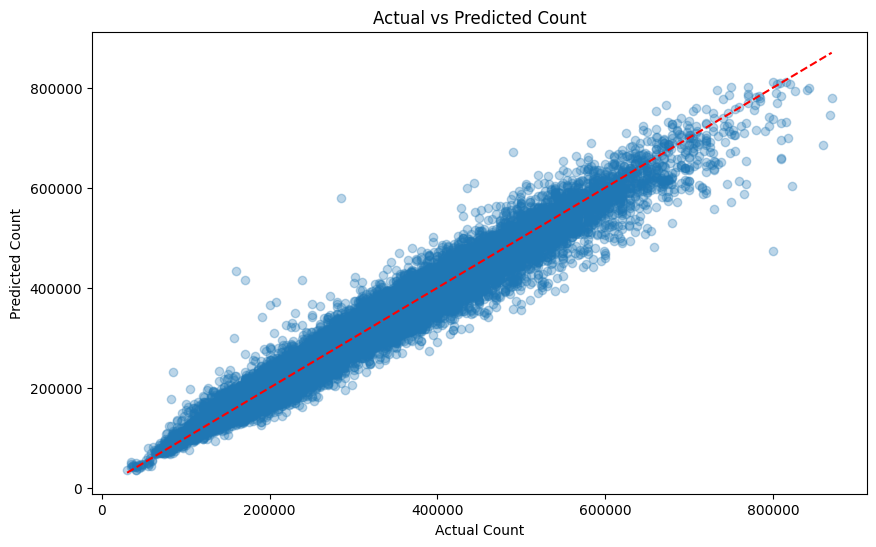

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.title('Actual vs Predicted Count')
plt.show()

결과 시각화

이 코드는 실제 값(y_test)과 예측 값(y_pred_test) 간의 관계를 시각화하기 위해 산점도(scatter plot)를 그리는 것입니다. 이를 통해 모델이 얼마나 잘 예측했는지 직관적으로 확인할 수 있습니다. 

-그래프 크기 설정:

plt.figure(figsize=(10, 6))는 그래프의 크기를 설정합니다. figsize 파라미터는 그래프의 가로 및 세로 크기를 인치 단위로 지정합니다. 여기서는 가로 10인치, 세로 6인치로 설정했습니다.

-산점도 그리기:

plt.scatter(y_test, y_pred_test, alpha=0.3)는 산점도를 그립니다.
y_test는 x축에, y_pred_test는 y축에 매핑됩니다.
alpha=0.3는 점의 투명도를 설정합니다. 값이 0에 가까울수록 더 투명해지고, 1에 가까울수록 불투명해집니다. 여기서는 점의 겹침을 방지하고 더 잘 보이도록 하기 위해 0.3으로 설정했습니다.

-참고선 그리기:

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')는 빨간색 점선으로 참고선을 그립니다.

[y_test.min(), y_test.max()]는 실제 값의 최소값과 최대값을 나타내며, 이 값을 x축과 y축에 동일하게 사용하여 45도 대각선을 만듭니다.

이 선은 완벽한 예측을 나타내며, 모든 점이 이 선 위에 위치하면 모델이 완벽하게 예측한 것입니다.

-축 레이블 설정:

plt.xlabel('Actual Count')는 x축의 레이블을 "Actual Count"로 설정합니다.

plt.ylabel('Predicted Count')는 y축의 레이블을 "Predicted Count"로 설정합니다.

-그래프 제목 설정:

plt.title('Actual vs Predicted Count')는 그래프의 제목을 "Actual vs Predicted Count"로 설정합니다.

-그래프 표시:

plt.show()는 설정한 그래프를 화면에 표시합니다.

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

결과적으로, 이 그래프는 실제 값과 예측 값 간의 관계를 시각적으로 보여줍니다. 점들이 빨간 점선(45도 대각선)에 가까울수록 모델의 예측이 정확하다는 것을 의미합니다. 점들이 이 선에서 멀리 떨어져 있을수록 예측 오류가 크다는 것을 시사합니다.